In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import array_ops

from influence.plot_utils import show_graph
from models.svm import SupportVectorMachine

## Derivation for SVM

Suppose $x^{1\times p}, X^{n\times p}, y^{n\times 1}, C^{1\times 1}$.
$$
\begin{split}
R_{emp} = \frac{1}{n}\left[tlog(1+exp(\frac{1-y^{\top}X\beta}{t})) + C\beta^T\beta\right] \qquad&(1\times 1) \\
\nabla_{\beta}R_{emp} = -\frac{1}{n}\frac{X^{\top}y}{t}exp(\frac{1-y^{\top}X\beta}{t})\frac{1}{1+exp(\frac{1-y^{\top}X\beta}{t})}t + \frac{2C}{n}\beta \\
= -\frac{1}{n}X^{\top}y(1-\frac{1}{1+exp(\frac{1-y^{\top}X\beta}{t})}) + \frac{2C}{n}\beta\\
\nabla^2_{\beta}R_{emp} = -\frac{1}{n}\frac{X^{\top}yy^{\top}X}{t}exp(\frac{1-y^{\top}X\beta}{t})(1+exp(\frac{1-y^{\top}X\beta}{t}))^{-2} + \frac{2C}{n}I_p \qquad&( p\times p)\\
\end{split}
$$
For some fixed validation or training point $z = (x,y)$
$$
\begin{split}
L(z;\hat{\beta}) = tlog(1+exp(\frac{1-y^{\top}X\hat{\beta}}{t})) + \frac{C}{n}\hat{\beta}^T\hat{\beta} \qquad&(1\times 1)\\
\nabla_{\beta}L(z;\hat{\beta}) = -\frac{1}{n}yx(1-\frac{1}{1+exp(\frac{1-yx^{\top}\hat{\beta}}{t})}) + \frac{2C}{n}\hat{\beta} \qquad&(p\times 1)\\
p = (\nabla^2_{\beta}R_{emp})^{-1}\nabla_{\beta}L(z_{te};\hat{\beta})\qquad&(p\times 1), \text{ Hessian-vector product}\\
u := \nabla_{\beta}L(z_{tr})=-\frac{1}{n}yx_{tr}(1-\frac{1}{1+exp(\frac{1-yx_{tr}^{\top}\hat{\beta}}{t})}) + \frac{2C}{n}\hat{\beta} \qquad&(1\times p), \text{ Gradient of loss of 1 training point}\\
\mathcal{I}_{loss}(\color{red}{z_{tr}}, \color{blue}{z_{te}}) =  \qquad&(1\times 1)
\end{split}
$$

In [2]:
df = pd.read_csv('data/svm_10.csv')
n = len(df)
X = df.values[:, 0:10]
y = df.values[:, -1].reshape(n, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)
n, p = X_train.shape

(80, 10)
(20, 10)
(80, 1)
(20, 1)


In [3]:
model = SupportVectorMachine(
    model_name='SVM',
    eta=0.01,
    C=0.1,
    t=0.1
)
model.fit(X_train, y_train, n_iter=10000)
y_hat = model.predict(X_train)

Step 0: loss = 1.00000465 (0.063 sec)
Step 1000: loss = 0.70532620 (0.000 sec)
Step 2000: loss = 0.70400560 (0.000 sec)
Step 3000: loss = 0.70384485 (0.000 sec)
Step 4000: loss = 0.70382529 (0.000 sec)
Step 5000: loss = 0.70382309 (0.000 sec)
Step 6000: loss = 0.70382279 (0.016 sec)
Step 7000: loss = 0.70382273 (0.000 sec)
Step 8000: loss = 0.70382273 (0.000 sec)
Step 9000: loss = 0.70382279 (0.000 sec)


In [8]:
show_graph(tf.get_default_graph())

In [4]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test, method='brute-force')

Fetch training loss gradients (0.141 sec)
Wall time: 219 ms


In [5]:
%%time
I_loss_loo = model.leave_one_out_refit(
    X_test, y_test, n_iter=1000)

LOO Fold 0: loss = 0.70706534 (0.625 sec)
LOO Fold 8: loss = 0.71244854 (0.641 sec)
LOO Fold 16: loss = 0.69073665 (0.625 sec)
LOO Fold 24: loss = 0.71258700 (0.594 sec)
LOO Fold 32: loss = 0.70295984 (0.609 sec)
LOO Fold 40: loss = 0.71186584 (0.578 sec)
LOO Fold 48: loss = 0.71250731 (0.594 sec)
LOO Fold 56: loss = 0.69230330 (0.594 sec)
LOO Fold 64: loss = 0.70286244 (0.906 sec)
LOO Fold 72: loss = 0.71246910 (0.735 sec)
Wall time: 52.7 s


"\naxes[1,1].update({\n    'title':'Colored & Translated by different Validation Points',\n    'yticks': []})\n_ = axes[1,2].update({\n    'title':'Colored & Translated by different Validation Points',\n    'yticks': []})\n"

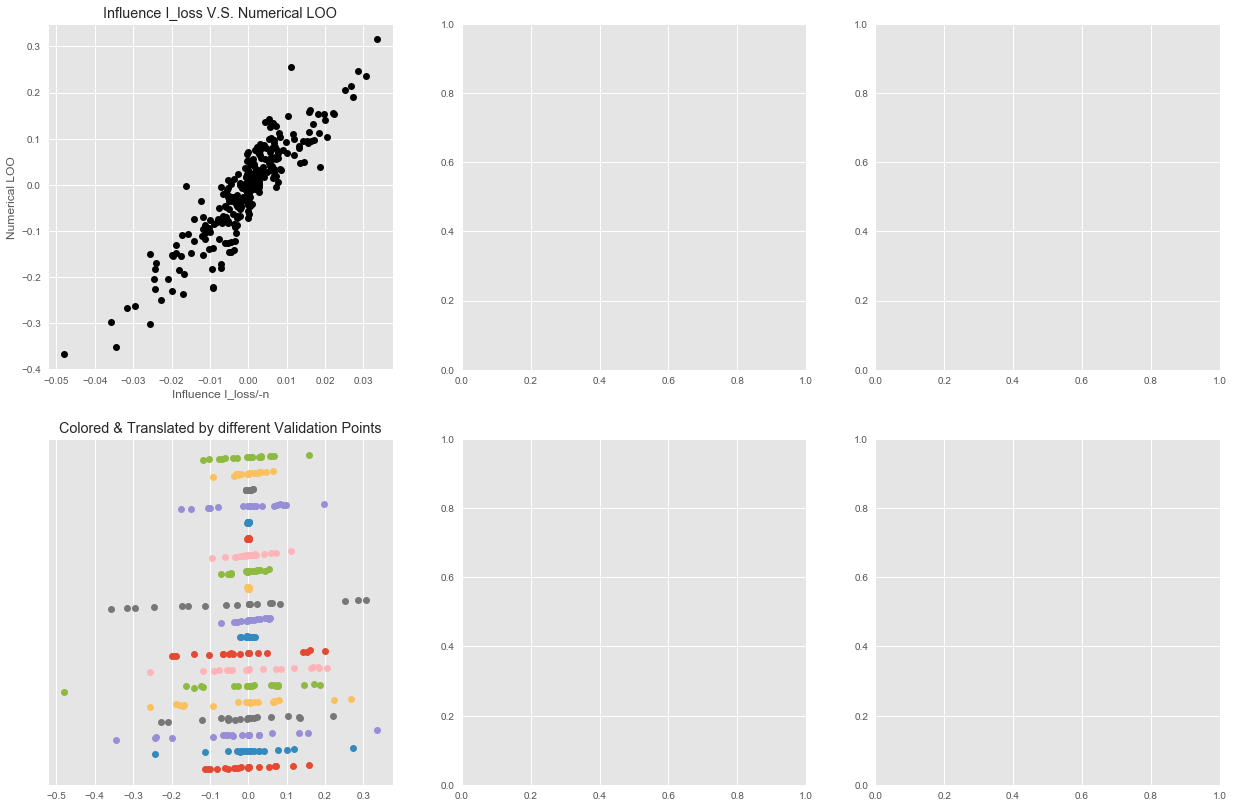

In [8]:
fig, axes = plt.subplots(2, 3 ,figsize=(21,14))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0,0].plot(I_loss_bf[j,:]/(-n_tr*10), I_loss_loo[j,:], 
                 'o', color='black')
    axes[1,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    """
    axes[0,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:], 
                 'o', color='black')
    axes[0,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:], 
                 'o', color='black')
    
    axes[1,0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')
    axes[1,1].plot(I_loss_bf[j,:]/(-n_tr), loo_loss_cf[j,:]+j, 'o')
    axes[1,2].plot(I_loss_loo[j,:], loo_loss_cf[j,:]+j, 'o')
    """

axes[0,0].update({
    'title':'Influence I_loss V.S. Numerical LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Numerical LOO'})
"""
axes[0,1].update({
    'title':'Influence I_loss V.S. Closeform LOO',
    'xlabel': 'Influence I_loss/-n',
    'ylabel': 'Closeform LOO'})
axes[0,2].update({
    'title':'Numerical LOO V.S. Closeform LOO',
    'xlabel': 'Numerical LOO',
    'ylabel': 'Closeform LOO'})
"""
axes[1,0].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
"""
axes[1,1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
_ = axes[1,2].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})
"""